In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor,RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
import streamlit as st

In [108]:
dfs=pd.read_csv("AB_NYC_2019.csv")
dfs.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [109]:
dfs.drop(columns=["id","name","host_id","host_name"],inplace=True)

In [110]:
dfs.isnull().sum()

neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [111]:
dfs.dropna(inplace=True)

In [112]:
dfs.shape

(38843, 12)

In [113]:
df=dfs.sample(n=5000,random_state=42)
df.to_csv("cleaned_data.csv",index=False)
df.shape

(5000, 12)

In [114]:
df["last_review"] = pd.to_datetime(df["last_review"])
df["year"]=df["last_review"].dt.year
df["month"]=df["last_review"].dt.month
df["day"]=df["last_review"].dt.day_of_week

In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 31762 to 1872
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   neighbourhood_group             5000 non-null   object        
 1   neighbourhood                   5000 non-null   object        
 2   latitude                        5000 non-null   float64       
 3   longitude                       5000 non-null   float64       
 4   room_type                       5000 non-null   object        
 5   price                           5000 non-null   int64         
 6   minimum_nights                  5000 non-null   int64         
 7   number_of_reviews               5000 non-null   int64         
 8   last_review                     5000 non-null   datetime64[ns]
 9   reviews_per_month               5000 non-null   float64       
 10  calculated_host_listings_count  5000 non-null   int64         
 11  avail

In [116]:
df.drop(columns=["last_review"],inplace=True)

In [117]:
label=LabelEncoder()
df["neighbourhood"]=label.fit_transform(df["neighbourhood"])
df["neighbourhood_group"]=label.fit_transform(df["neighbourhood_group"])
df["room_type"]=label.fit_transform(df["room_type"])

In [118]:
df.drop(columns=["neighbourhood"],inplace=True)

In [120]:
df.duplicated().sum()

np.int64(0)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 [Text(0, 0, 'neighbourhood_group'),
  Text(1, 0, 'latitude'),
  Text(2, 0, 'longitude'),
  Text(3, 0, 'room_type'),
  Text(4, 0, 'price'),
  Text(5, 0, 'minimum_nights'),
  Text(6, 0, 'number_of_reviews'),
  Text(7, 0, 'reviews_per_month'),
  Text(8, 0, 'calculated_host_listings_count'),
  Text(9, 0, 'availability_365'),
  Text(10, 0, 'year'),
  Text(11, 0, 'month'),
  Text(12, 0, 'day')])

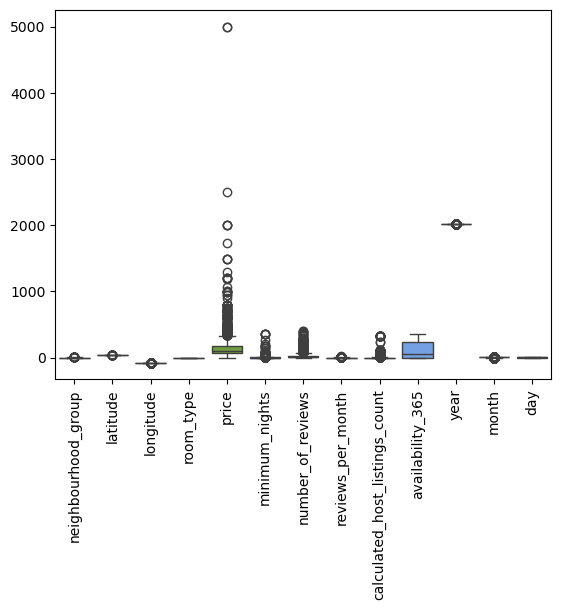

In [121]:
sns.boxplot(data=df)
plt.xticks(rotation=90)

<Axes: >

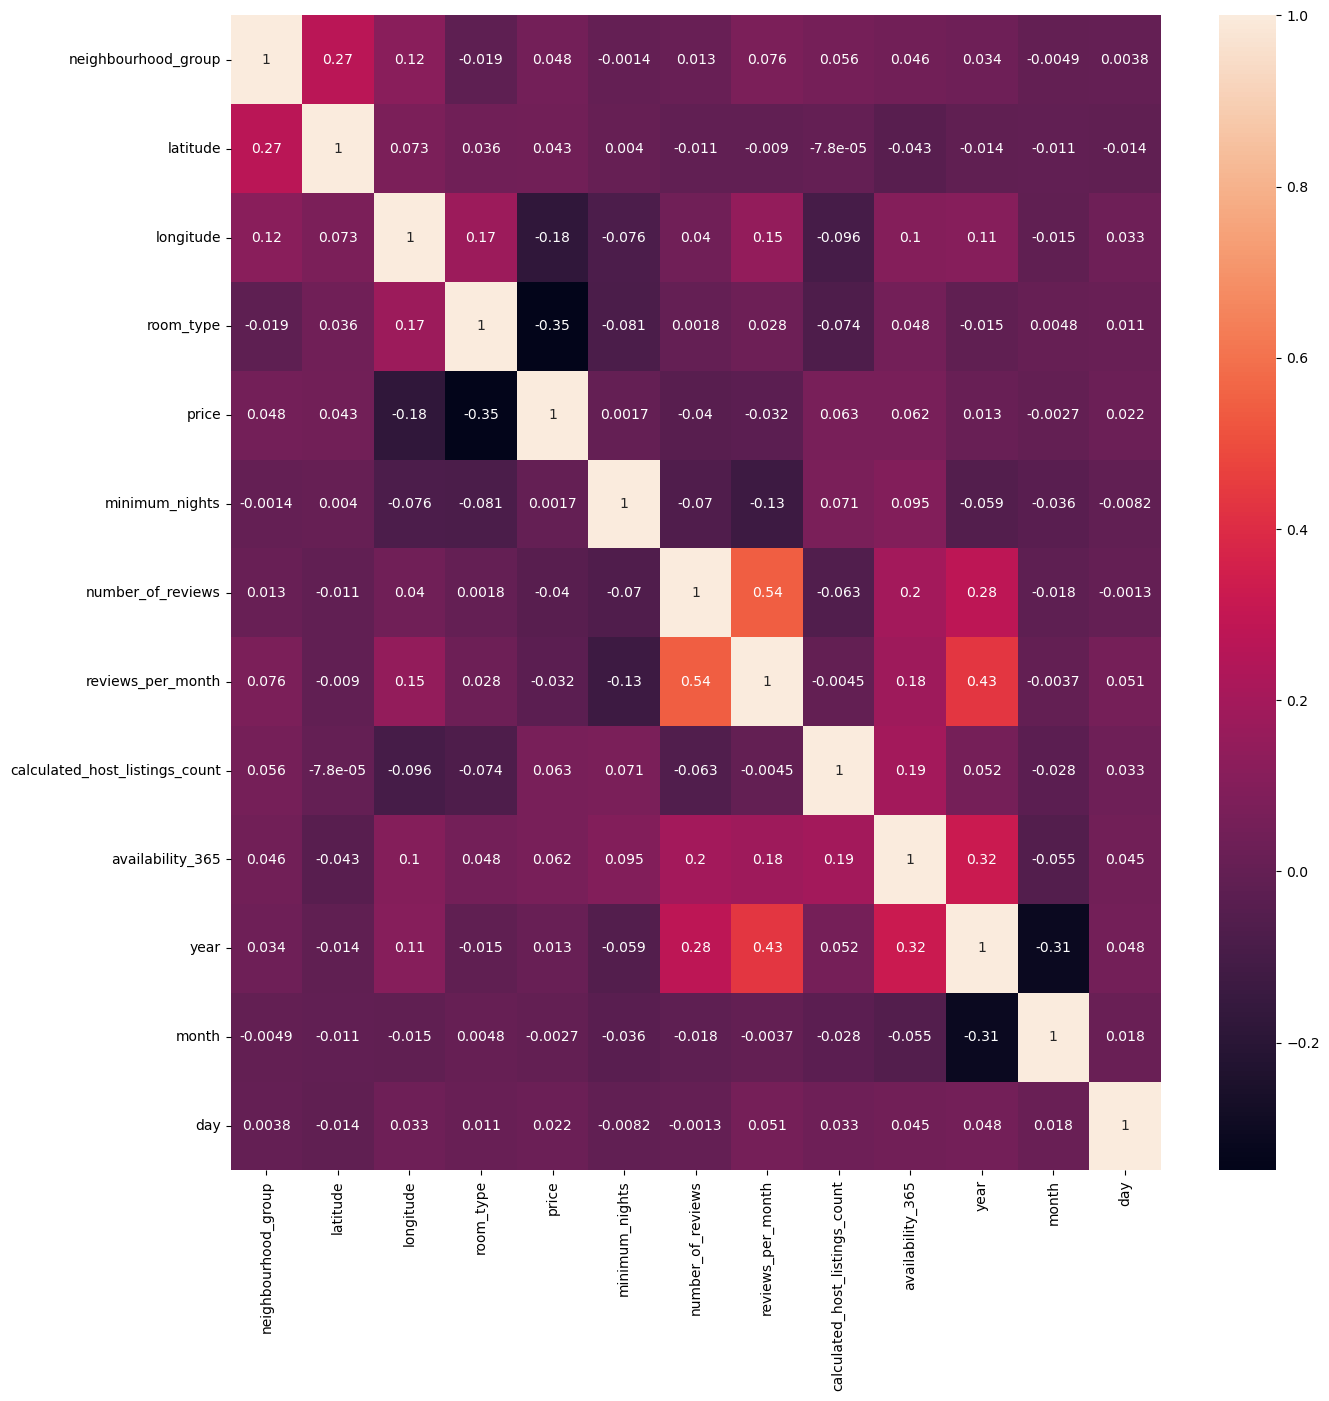

In [122]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(),annot=True)

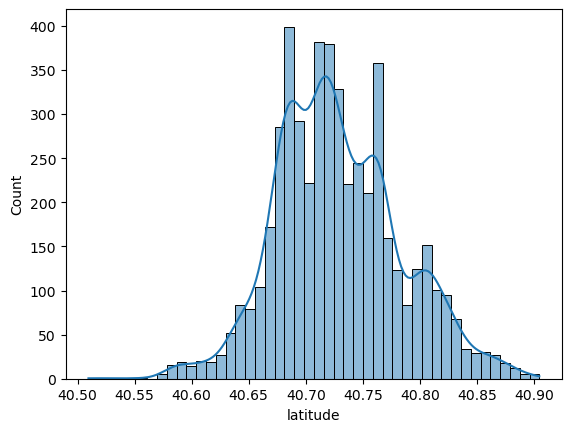

In [123]:
sns.histplot(df["latitude"],kde=True)
df["price"]=np.log1p(df["price"])
df["reviews_per_month"]=np.log1p(df["reviews_per_month"])
df["calculated_host_listings_count"]=np.cbrt(np.log1p(df["calculated_host_listings_count"]))

In [124]:
lower = df["price"].quantile(0.01)
upper = df["price"].quantile(0.99)

df["price_capped"] = df["price"].clip(lower, upper)

In [125]:
models={
    "LinearRegression":LinearRegression(),
    "Lasso":Lasso(),
    "Ridge":Ridge(),
    "RandomForestRegressor":RandomForestRegressor(),
    "DecisionTreeRegressor":DecisionTreeRegressor(),
    "KneighborsRegressor":KNeighborsRegressor(),
    "SVM Regressor":SVR(kernel="rbf"),
    "Adaboost":AdaBoostRegressor(),
    "gradientboost":GradientBoostingRegressor(),
    "xgboost":XGBRegressor()
}

In [126]:
param_grids = {
    "LinearRegression": {"fit_intercept": [True, False]},
    "Lasso": {"alpha": [0.01, 0.1, 1]},
    "Ridge": {"alpha": [0.01, 0.1, 1]},
    "RandomForestRegressor": {"n_estimators": [100, 200], "max_depth": [None, 10]},
    "DecisionTreeRegressor": {"max_depth": [None, 10], "min_samples_split": [2, 5]},
    "KneighborsRegressor": {"n_neighbors": [3, 5, 7]},
    "SVM Regressor": {"C": [0.1, 1, 10], "epsilon": [0.1, 0.2]},
    "Adaboost": {"n_estimators": [50, 100], "learning_rate": [0.1, 0.5]},
    "gradientboost": {"n_estimators": [100, 200], "learning_rate": [0.05, 0.1]},
    "xgboost": {"n_estimators": [100, 200], "learning_rate": [0.05, 0.1]}
}


In [127]:
x=df.drop(columns=["price_capped"])
y=df["price_capped"]
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)
scaler=StandardScaler()
x_train=scaler.fit_transform(x_train)
x_test=scaler.transform(x_test)

In [128]:
mse=[]
mae=[]
r2s=[]
adj_r2=[]
bestp=[]
n = x_test.shape[0]
p = x_train.shape[1]
for i,j in models.items():
    param_grid=param_grids[i]
    grid=GridSearchCV(j,cv=5,param_grid=param_grid,scoring="r2")
    grid.fit(x_train,y_train)
    best_param=grid.best_params_
    model=grid.best_estimator_
    y_pred_log = model.predict(x_test)
    y_pred = np.expm1(y_pred_log)
    y_test_orig = np.expm1(y_test) 
    r2 = r2_score(y_test_orig, y_pred)
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    mse.append(mean_squared_error(y_test_orig, y_pred))
    mae.append(mean_absolute_error(y_test_orig, y_pred))
    r2s.append(r2)
    adj_r2.append(adjusted_r2)
    bestp.append(best_param)    


In [129]:
model_names = list(models.keys())
result = pd.DataFrame({
    "MSE": mse,
    "MAE": mae,
    "R2": r2s,
    "Adjusted_R2": adj_r2,
    "Best Param":bestp
}, index=model_names)
result["RMSE"]=np.sqrt(result["MSE"])

In [130]:
result.head(10)

,MSE,MAE,R2,Adjusted_R2,Best Param,RMSE
LinearRegression,10678.577261,9.874023,0.110588,0.098862,{'fit_intercept': True},103.337202
Lasso,10678.339909,10.647081,0.110608,0.098882,{'alpha': 0.01},103.336053
Ridge,10633.896098,9.885320,0.114310,0.102632,{'alpha': 1},103.120784
RandomForestRegressor,0.253852,0.087328,0.999979,0.999979,"{'max_depth': 10, 'n_estimators': 200}",0.503837
DecisionTreeRegressor,1.163267,0.094331,0.999903,0.999902,"{'max_depth': None, 'min_samples_split': 5}",1.078549
KneighborsRegressor,2056.973944,25.711572,0.828676,0.826417,{'n_neighbors': 5},45.353875
SVM Regressor,554.125982,8.486349,0.953847,0.953239,"{'C': 10, 'epsilon': 0.1}",23.539881
Adaboost,100.787670,5.565971,0.991605,0.991495,"{'learning_rate': 0.5, 'n_estimators': 100}",10.039306
gradientboost,0.223082,0.092194,0.999981,0.999981,"{'learning_rate': 0.05, 'n_estimators': 200}",0.472316
xgboost,5.134250,0.658636,0.999572,0.999567,"{'learning_rate': 0.1, 'n_estimators': 100}",2.265888


In [131]:
param_grid={
    "n_estimators":[100,200],
    "max_depth":[None,10]
}
grid=GridSearchCV(RandomForestRegressor(),cv=5,param_grid=param_grid,scoring="r2")
grid.fit(x_train,y_train)
model=grid.best_estimator_
y_pred_log = model.predict(x_test)
y_pred = np.expm1(y_pred_log)
y_test_orig = np.expm1(y_test)
print("r2_score",r2_score(y_test_orig,y_pred))
print("mean squared error:",mean_squared_error(y_test_orig,y_pred))
print("mean_absolute_error:",mean_absolute_error(y_test_orig,y_pred)) 

r2_score 0.9999675111416867
mean squared error: 0.39007221297452876
mean_absolute_error: 0.09346449594539746


In [132]:
import pickle
with open("model.sav", "wb") as f:
    pickle.dump((model), f)
with open("model.sav", "rb") as f:
    loaded_model= pickle.load(f)